## Analyses and predictions of English Premier League and Manchester United Results Using Machine Learning

- Data: English Premier League 1993-1994 to 2022-2023 (last season)
- Link: https://www.kaggle.com/datasets/irkaal/english-premier-league-results
- Credit to Alvin @ Kaggle
- Abbreviation:
    - MUFC/Man United: Manchester United Football Club
    - EPL: English Premier League
- Other sources: 
    - Creating an ML model for predicting English Premiership results (or using Machine Learning to figure out if Arsenal will return to the Champions League in 2020–2021) by Icaro on Medium
        - https://medium.com/analytics-vidhya/creating-an-ml-model-for-predicting-english-premiership-results-or-using-machine-learning-to-875b369c1b48
    - Predicting Premier League match results based on historic data by Arman Tadjrishi
        - https://armantee.github.io/predicting/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

### Load data

In [2]:
# Load data
# Notice there might be UTF-8 code warning when reading the data
# May need to change the format of the column DateTime

data_path = "/home/ychen/Downloads/results.csv"
epl_data = pd.read_csv(data_path, index_col=0)

#### HEADERS / COLUMN NAMES    
- Season: Match Season    
- DateTime: Match Date and Time (yyyy-mm-dd hh:mm:ss)    
- HomeTeam: Home Team    
- AwayTeam: Away Team    
- FTHG: Full Time Home Team Goals
- FTAG: Full Time Away Team Goals
- FTR: Full Time Result (H=Home Win, D=Draw, A=Away Win)
- HTHG: Half Time Home Team Goals
- HTAG: Half Time Away Team Goals
- HTR: Half Time Result (H=Home Win, D=Draw, A=Away Win)
- Referee: Match Referee
- HS: Home Team Shots
- AS: Away Team Shots
- HST: Home Team Shots on Target
- AST: Away Team Shots on Target
- HC: Home Team Corners
- AC: Away Team Corners
- HF: Home Team Fouls Committed
- AF: Away Team Fouls Committed
- HY: Home Team Yellow Cards
- AY: Away Team Yellow Cards
- HR: Home Team Red Cards
- AR: Away Team Red Cards

*From data description*

In [3]:
# EPL data at a glance
print("Data shape: ", epl_data.shape)
epl_data.head()

Data shape:  (11113, 22)


,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
Season,,,,,,,,,,,,,,,,,,,,,
1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print("Number of teams:", len(epl_data['HomeTeam'].unique()))
epl_data['HomeTeam'].unique()

Number of teams: 50


array(['Arsenal', 'Aston Villa', 'Chelsea', 'Liverpool', 'Man City',
       'Newcastle', 'Oldham', 'Sheffield United', 'Southampton',
       'West Ham', 'Norwich', 'Tottenham', 'Everton', 'Ipswich', 'Leeds',
       'Wimbledon', 'Blackburn', 'Coventry', 'Man United', 'QPR',
       'Sheffield Weds', 'Swindon', 'Crystal Palace', 'Leicester',
       "Nott'm Forest", 'Bolton', 'Middlesbrough', 'Derby', 'Sunderland',
       'Barnsley', 'Charlton', 'Watford', 'Bradford', 'Fulham',
       'Birmingham', 'West Brom', 'Portsmouth', 'Wolves', 'Wigan',
       'Reading', 'Hull', 'Stoke', 'Burnley', 'Blackpool', 'Swansea',
       'Cardiff', 'Bournemouth', 'Brighton', 'Huddersfield', 'Brentford'],
      dtype=object)

There are a total of 44 teams in this dataset (mutliple seasons). The last 3 teams will be relegated to the EFL Championship, while the top 3 teams in the EFL Championship will be promoted to the premier league. Thus, every season will have 38 teams.

---
### Preprocessing data
Notice that we have a lot of NaNs in the first few columns. Normally, we can get rid of these values and interpolate using various methods. In addition, one can also check the outlier or duplicate values that are due to instrumental error. However, this dataset is the public records, which saves results and statistics for each game since season 1993-1994. Therefore, there is no reason for us to overprocess the dataset.
*This step is only for exploring data. We will process later for machine learning.*

In [5]:
# Remove rows that exist NaNs
epl_data.dropna(inplace=True)
print("Data shape is {} now.".format(epl_data.shape))
# let’s check if our dataset has any null values
print("How many NaNs do we have now?", epl_data.isnull().values.sum())

Data shape is (8289, 22) now.
How many NaNs do we have now? 0


We now have 8,289 rows (number of games) and 22 rows (features). 

In [6]:
# Meanwhile, extract statistics for MUFC
mufc_data = epl_data[(epl_data['HomeTeam'] == 'Man United') | 
                    (epl_data['AwayTeam'] == 'Man United')]
print("MUFC data shape:", mufc_data.shape)
mufc_data.head()

MUFC data shape: (829, 22)


,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
Season,,,,,,,,,,,,,,,,,,,,,
2000-01,2000-08-20T00:00:00Z,Man United,Newcastle,2,0,H,1.0,0.0,H,Steve Lodge,...,9.0,6.0,7.0,1.0,7.0,13.0,0.0,1.0,0.0,0.0
2000-01,2000-08-22T00:00:00Z,Ipswich,Man United,1,1,D,1.0,1.0,D,Jeff Winter,...,8.0,6.0,4.0,6.0,10.0,7.0,1.0,4.0,0.0,0.0
2000-01,2000-08-26T00:00:00Z,West Ham,Man United,2,2,D,0.0,1.0,A,Dermot Gallagher,...,8.0,5.0,7.0,5.0,12.0,9.0,1.0,0.0,0.0,0.0
2000-01,2000-09-05T00:00:00Z,Man United,Bradford,6,0,H,2.0,0.0,H,Ian Harris,...,12.0,4.0,5.0,1.0,12.0,10.0,0.0,1.0,0.0,0.0
2000-01,2000-09-09T00:00:00Z,Man United,Sunderland,3,0,H,1.0,0.0,H,Neale Barry,...,7.0,1.0,4.0,4.0,18.0,14.0,1.0,3.0,0.0,0.0


So for MUFC games from seasons 2000-2001 to 2021-2022, we have total 829 entries. Next, we will need to check the data type for each column since machine learning cannot be fed with values other than numbers.

In [7]:
# Show dataframe info
epl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8289 entries, 2000-01 to 2021-22
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  8289 non-null   object 
 1   HomeTeam  8289 non-null   object 
 2   AwayTeam  8289 non-null   object 
 3   FTHG      8289 non-null   int64  
 4   FTAG      8289 non-null   int64  
 5   FTR       8289 non-null   object 
 6   HTHG      8289 non-null   float64
 7   HTAG      8289 non-null   float64
 8   HTR       8289 non-null   object 
 9   Referee   8289 non-null   object 
 10  HS        8289 non-null   float64
 11  AS        8289 non-null   float64
 12  HST       8289 non-null   float64
 13  AST       8289 non-null   float64
 14  HC        8289 non-null   float64
 15  AC        8289 non-null   float64
 16  HF        8289 non-null   float64
 17  AF        8289 non-null   float64
 18  HY        8289 non-null   float64
 19  AY        8289 non-null   float64
 20  HR        8289 non-null   

Notice that we have three columns that are object type, i.e., FTR, HTR, and Referee. The first one is the full-time result, which will be used to compare our predicted results. The second is the half-time result. Although it might be related to our project too much, we would assume the HTR may be a sign for the FTR, especially for some teams. The last one is the referee. Let us take a look before making a decision.

In [8]:
# Deal with wrong name of Referee
epl_data['Referee'].unique()

array(['Rob Harris', 'Graham Barber', 'Barry Knight', "Andy D'Urso",
       'Dermot Gallagher', 'Mike Riley', 'Paul Durkin', 'Steve Dunn',
       'Alan Wiley', 'Steve Lodge', 'Graham Poll', 'Mark Halsey',
       'Jeff Winter', 'Peter Jones', 'Andy Hall', 'David Ellaray',
       'F Taylor', 'Rob Styles', 'Steve Bennett', 'Ian Harris',
       'Paul Taylor', 'Neale Barry', 'Mike Dean', 'Roy Burton',
       'Matt Messias', 'Clive Wilkes', 'N. S. Barry', 'P. A. Durkin',
       'C. R. Wilkes', 'R. Styles', 'J. T. Winter', 'G. P. Barber',
       'G. Poll', 'D. J. Gallagher', "A. P. D'Urso", 'P. Jones',
       'D. R. Elleray', 'S. W. Dunn', 'E. K. Wolstenholme', 'A. G. Wiley',
       'B. Knight', 'S. G. Bennett', 'U. D. Rennie', 'M. L Dean',
       'M. A. Riley', 'D. Pugh', 'P.A. Durkin', 'A.G. Wiley',
       'M. R. Halsey', 'M. L. Dean', 'J.T. Winter', 'M. D. Messias',
       'P. Dowd', 'C. J. Foy', 'Wiley, A. G.', 'Elleray, D. R.',
       'Winter, J. T.', 'Wolstenholme, E. K.', 'Dunn, S. W.'

We can see some names are recorded in a different way, but they are actually the same person. For example, Mike Dean, M. L Dean, and M. Dean are the same referee. Also, there are some names containing special character.

In [9]:
names = np.array(epl_data['Referee']).tolist()
normalized_names = []
for name in names:
    # If there a comma, e.g., 'Poll, G.'
    if ',' in name:
        last, first = name.split(',', 1)
    else:
        parts = name.split()
        last = parts[-1]
        first = ' '.join(parts[:-1])
    
    # Remove space 
    first = first.replace('.', '').strip()
    last = last.strip()
    # Replace special character
    first_initial = first[0].replace('�', '')
    # Final name format, e.g., 'D England'
    normalized_name = first_initial + ' ' + last
    normalized_names.append(normalized_name)

# Copy values to epl_data
epl_data['Referee'] = normalized_names

In [10]:
# Check again
epl_data['Referee'].unique()

array(['R Harris', 'G Barber', 'B Knight', "A D'Urso", 'D Gallagher',
       'M Riley', 'P Durkin', 'S Dunn', 'A Wiley', 'S Lodge', 'G Poll',
       'M Halsey', 'J Winter', 'P Jones', 'A Hall', 'D Ellaray',
       'F Taylor', 'R Styles', 'S Bennett', 'I Harris', 'P Taylor',
       'N Barry', 'M Dean', 'R Burton', 'M Messias', 'C Wilkes',
       'D Elleray', 'E Wolstenholme', 'U Rennie', 'D Pugh', 'P Dowd',
       'C Foy', 'N Yates', 'R Martin', 'H Webb', 'P Walton',
       'M Clattenburg', 'M Atkinson', 'P Crossley', 'A Marriner',
       ' Rennie', ' Foy', ' Wiley', ' Gallagher', " D'Urso", ' Webb',
       ' Atkinson', ' Barry', ' Dunn', 'R Beeby', 'I Williamson',
       'L Mason', 'K Stroud', 'S Tanner', 'L Probert', 'D Gallagh',
       'D Gallaghe', 'S Attwell', 'M Jones', 'K Friend', 'A Taylor',
       'M Oliver', 'N Swarbrick', 'J Moss', 'R East', 'C Pawson',
       'R Madley', 'P Tierney', 'G Scott', 'S Hooper', 'C Kavanagh',
       'l Mason', 'D Coote', 'A Madley', 'O Langford', 

In [11]:
epl_data.head()

,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
Season,,,,,,,,,,,,,,,,,,,,,
2000-01,2000-08-19T00:00:00Z,Charlton,Man City,4,0,H,2.0,0.0,H,R Harris,...,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0
2000-01,2000-08-19T00:00:00Z,Chelsea,West Ham,4,2,H,1.0,0.0,H,G Barber,...,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0
2000-01,2000-08-19T00:00:00Z,Coventry,Middlesbrough,1,3,A,1.0,1.0,D,B Knight,...,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0
2000-01,2000-08-19T00:00:00Z,Derby,Southampton,2,2,D,1.0,2.0,A,A D'Urso,...,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0
2000-01,2000-08-19T00:00:00Z,Leeds,Everton,2,0,H,2.0,0.0,H,D Gallagher,...,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0


Text(0, 0.5, 'Referees')

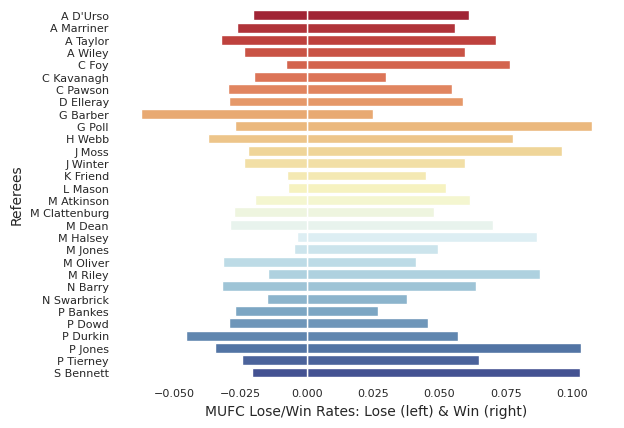

In [12]:
# Win, referee, count
mufc_win = epl_data[((epl_data['HomeTeam'] == 'Man United') & (epl_data['FTR'] == 'H')) | 
                    ((epl_data['AwayTeam'] == 'Man United') & (epl_data['FTR'] == 'A'))]
mufc_win_referee = mufc_win.groupby('Referee', as_index=False)['FTR'].count()

# Lose, referee, count
mufc_lose = epl_data[((epl_data['HomeTeam'] == 'Man United') & (epl_data['FTR'] == 'A')) | 
                    ((epl_data['AwayTeam'] == 'Man United') & (epl_data['FTR'] == 'H'))]
mufc_lose_referee = mufc_lose.groupby('Referee', as_index=False)['FTR'].count()

# Referee, total count since one may have different career lengths
referee_total = epl_data.groupby('Referee', as_index=False)['FTR'].count()

# All information
mufc_referee_win_temp = referee_total.merge(mufc_win_referee, how='left', 
                                            left_on='Referee', right_on='Referee')
mufc_referee_total = mufc_referee_win_temp.merge(mufc_lose_referee, how='left', 
                                                 left_on='Referee', right_on='Referee')
mufc_referee_total['winrate'] = round(mufc_referee_total['FTR_y']/mufc_referee_total['FTR_x'],4)
mufc_referee_total['loserate'] = -round(mufc_referee_total['FTR']/mufc_referee_total['FTR_x'],4)
mufc_referee_total.drop(columns=['FTR_x','FTR_y','FTR'], inplace=True)
mufc_referee_total.dropna(inplace=True)

sns.set_style("darkgrid", {"axes.facecolor": "1"})
ax = sns.barplot(x='winrate', y='Referee', data=mufc_referee_total, 
                 hue='Referee', palette='RdYlBu')
ax = sns.barplot(x='loserate', y='Referee', data=mufc_referee_total, 
                 hue='Referee', palette='RdYlBu')
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=8)
ax.set_xlabel('MUFC Lose/Win Rates: Lose (left) & Win (right)', fontsize=10)
ax.set_ylabel('Referees', fontsize=10)

The above figure shows MUFC loss and win rates with each referee, where the rate is w.r.t. the total games this referee had. The left portion represents the loss rate, where the negative sign is artificial and is only for present purposes. The right portion is the win rate. MUFC performed significantly differently. The win and lose rates are even the same under Neale Barry. The overall tendency is that they have greater win rates than lose, which is quite expected since they finally won 7 trophies in this given dataset (after removing NaNs). But anyway, this is a tricky factor that every football fan will have a different thought. For project purposes, we would remove the Referee here.

In [13]:
epl_data.drop(columns='Referee', inplace=True)
epl_data.shape

(8289, 21)

In [14]:
mufc_data = epl_data[(epl_data['HomeTeam'] == 'Man United') | 
                    (epl_data['AwayTeam'] == 'Man United')]
mufc_data.shape

(829, 21)

As mentioned by Icaro on Medium, the datetime of match does not matter in this project. Instead, whether the team has enough days to rest really matters. From supporter's perspective, the team will usually perform better on weekend, while they be tired for mid week matches since they only rest for 3 days. Thus, we will adjust datetime by weekday and drop irrelevant features again.

In [15]:
epl_data["matchDay"] = pd.to_datetime(epl_data["DateTime"], infer_datetime_format=True).dt.day_name()
epl_data.drop('DateTime', axis=1, inplace=True)
epl_data.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HC,AC,HF,AF,HY,AY,HR,AR,matchDay
Season,,,,,,,,,,,,,,,,,,,,,
2000-01,Charlton,Man City,4,0,H,2.0,0.0,H,17.0,8.0,...,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,Saturday
2000-01,Chelsea,West Ham,4,2,H,1.0,0.0,H,17.0,12.0,...,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,Saturday
2000-01,Coventry,Middlesbrough,1,3,A,1.0,1.0,D,6.0,16.0,...,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,Saturday
2000-01,Derby,Southampton,2,2,D,1.0,2.0,A,6.0,13.0,...,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,Saturday
2000-01,Leeds,Everton,2,0,H,2.0,0.0,H,17.0,12.0,...,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,Saturday


---
### Visualize data

In [16]:
epl_data_stat = epl_data.describe()
epl_data_stat

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
count,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000,8289.000000
mean,1.519242,1.155507,0.681506,0.506816,13.503921,10.644589,6.117264,4.768247,6.081795,4.784292,11.379057,11.873447,1.415852,1.746532,0.062854,0.089396
std,1.299000,1.142826,0.831712,0.723624,5.258636,4.583010,3.327521,2.792965,3.095070,2.728954,3.784956,3.957427,1.189134,1.267468,0.253416,0.297341
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,7.000000,4.000000,3.000000,4.000000,3.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,6.000000,4.000000,6.000000,4.000000,11.000000,12.000000,1.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,13.000000,8.000000,6.000000,8.000000,6.000000,14.000000,14.000000,2.000000,3.000000,0.000000,0.000000
max,9.000000,9.000000,5.000000,5.000000,43.000000,30.000000,24.000000,20.000000,20.000000,19.000000,33.000000,29.000000,7.000000,9.000000,3.000000,2.000000


In [17]:
mufc_data_stat = mufc_data.describe()
mufc_data_stat

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
count,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000
mean,1.579011,1.220748,0.733414,0.527141,14.089264,10.835947,6.498191,5.053076,5.930036,4.621230,11.389626,11.600724,1.521110,1.751508,0.049457,0.085645
std,1.384034,1.207166,0.877857,0.758717,5.615433,4.551064,3.651690,2.954908,3.312606,2.765616,3.763406,3.733715,1.222218,1.283870,0.233054,0.300802
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,7.000000,4.000000,3.000000,3.000000,3.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,13.000000,10.000000,6.000000,5.000000,5.000000,4.000000,11.000000,11.000000,1.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,9.000000,7.000000,8.000000,6.000000,14.000000,14.000000,2.000000,3.000000,0.000000,0.000000
max,9.000000,6.000000,5.000000,4.000000,37.000000,29.000000,24.000000,18.000000,19.000000,16.000000,26.000000,25.000000,7.000000,7.000000,2.000000,2.000000


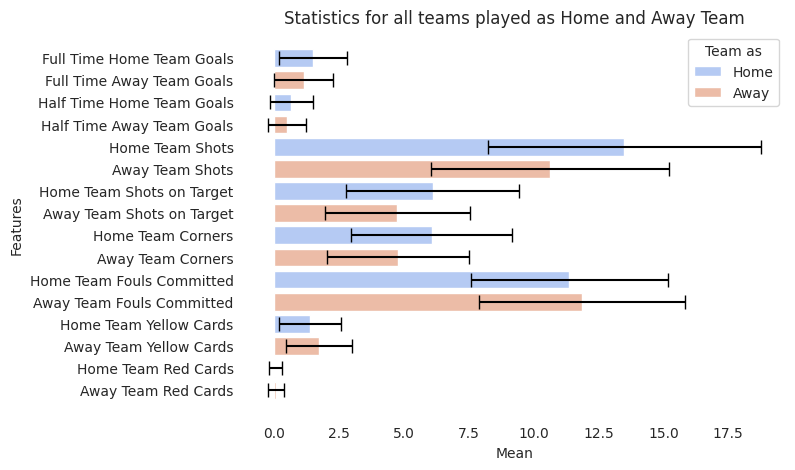

,index,mean,std,group
0,Full Time Home Team Goals,1.519242,1.299000,Home
1,Full Time Away Team Goals,1.155507,1.142826,Away
2,Half Time Home Team Goals,0.681506,0.831712,Home
3,Half Time Away Team Goals,0.506816,0.723624,Away
4,Home Team Shots,13.503921,5.258636,Home
5,Away Team Shots,10.644589,4.583010,Away
6,Home Team Shots on Target,6.117264,3.327521,Home
7,Away Team Shots on Target,4.768247,2.792965,Away
8,Home Team Corners,6.081795,3.095070,Home
9,Away Team Corners,4.784292,2.728954,Away


In [18]:
# ALL TEAMS
# Extract mean and std values
mean_std = epl_data_stat.loc[['mean', 'std']]
# Transpose dataframe in order to plot
mean_std_df = mean_std.T.reset_index()
mean_std_df['group'] = ['Away' if i % 2 != 0 else 'Home' for i in range(len(mean_std_df))]
  
mean_std_df['index'] = mean_std_df['index'].replace({
    'FTHG': 'Full Time Home Team Goals','FTAG': 'Full Time Away Team Goals',
    'HTHG': 'Half Time Home Team Goals','HTAG': 'Half Time Away Team Goals',
    'HS': 'Home Team Shots','AS': 'Away Team Shots',
    'HST': 'Home Team Shots on Target','AST': 'Away Team Shots on Target',
    'HC': 'Home Team Corners','AC': 'Away Team Corners',
    'HF': 'Home Team Fouls Committed','AF': 'Away Team Fouls Committed',
    'HY': 'Home Team Yellow Cards','AY': 'Away Team Yellow Cards',
    'HR': 'Home Team Red Cards','AR': 'Away Team Red Cards'
})

plt.figure(figsize=(7, 5))
sns.barplot(x="mean", y="index", data=mean_std_df, hue="group", palette="coolwarm")
plt.errorbar(x=mean_std_df['mean'], y=mean_std_df['index'], xerr=mean_std_df['std'], 
             fmt='none', c='black', capsize=5)
plt.title('Statistics for all teams played as Home and Away Team')
plt.xlabel('Mean')
plt.ylabel('Features')
plt.legend(title='Team as')
plt.show()
mean_std_df

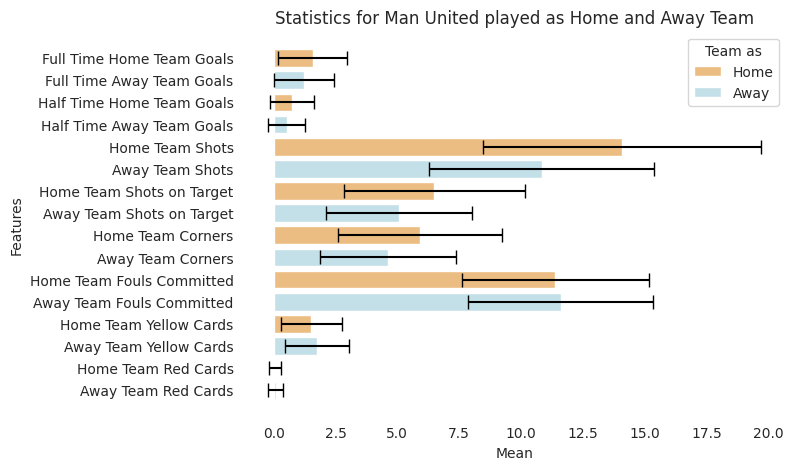

,index,mean,std,group
0,Full Time Home Team Goals,1.579011,1.384034,Home
1,Full Time Away Team Goals,1.220748,1.207166,Away
2,Half Time Home Team Goals,0.733414,0.877857,Home
3,Half Time Away Team Goals,0.527141,0.758717,Away
4,Home Team Shots,14.089264,5.615433,Home
5,Away Team Shots,10.835947,4.551064,Away
6,Home Team Shots on Target,6.498191,3.651690,Home
7,Away Team Shots on Target,5.053076,2.954908,Away
8,Home Team Corners,5.930036,3.312606,Home
9,Away Team Corners,4.621230,2.765616,Away


In [19]:
# MUFC Only
# Extract mean and std values
mufc_mean_std = mufc_data_stat.loc[['mean', 'std']]
# Transpose dataframe in order to plot
mufc_mean_std_df = mufc_mean_std.T.reset_index()
mufc_mean_std_df['group'] = ['Away' if i % 2 != 0 else 'Home' for i in range(len(mufc_mean_std_df))]
  
mufc_mean_std_df['index'] = mufc_mean_std_df['index'].replace({
    'FTHG': 'Full Time Home Team Goals','FTAG': 'Full Time Away Team Goals',
    'HTHG': 'Half Time Home Team Goals','HTAG': 'Half Time Away Team Goals',
    'HS': 'Home Team Shots','AS': 'Away Team Shots',
    'HST': 'Home Team Shots on Target','AST': 'Away Team Shots on Target',
    'HC': 'Home Team Corners','AC': 'Away Team Corners',
    'HF': 'Home Team Fouls Committed','AF': 'Away Team Fouls Committed',
    'HY': 'Home Team Yellow Cards','AY': 'Away Team Yellow Cards',
    'HR': 'Home Team Red Cards','AR': 'Away Team Red Cards'
})

plt.figure(figsize=(7,5))
sns.barplot(x="mean", y="index", data=mufc_mean_std_df, hue="group", palette="RdYlBu")
plt.errorbar(x=mufc_mean_std_df['mean'], y=mufc_mean_std_df['index'], xerr=mufc_mean_std_df['std'], 
             fmt='none', c='black', capsize=5)
plt.title('Statistics for Man United played as Home and Away Team')
plt.xlabel('Mean')
plt.ylabel('Features')
plt.legend(title='Team as')
plt.show()
mufc_mean_std_df

In [20]:
# Which team plays most on Wednesday or Tuesday?
epl_data_wed_tue = epl_data[epl_data['matchDay'].isin(['Tuesday', 'Wednesday'])]
# How many matches are on Tue or Weds
match_count_home = epl_data_wed_tue.groupby('HomeTeam', as_index=False)['FTR'].count()
match_count_away = epl_data_wed_tue.groupby('AwayTeam', as_index=False)['FTR'].count()
match_count_wed_tue = match_count_home.merge(match_count_away, how='left', 
                                            left_on='HomeTeam', right_on='AwayTeam')
match_count_wed_tue['total'] = match_count_wed_tue['FTR_x'] + match_count_wed_tue['FTR_y']
match_count_wed_tue.drop(columns=['AwayTeam','FTR_x','FTR_y'], inplace=True)

# How many matches totally
match_all_away = epl_data.groupby('AwayTeam', as_index=False)['FTR'].count()
match_all_home = epl_data.groupby('HomeTeam', as_index=False)['FTR'].count()
match_all = match_all_home.merge(match_all_away, how='left', 
                                            left_on='HomeTeam', right_on='AwayTeam')
match_all['total'] = match_all['FTR_x'] + match_all['FTR_y']
match_all.drop(columns=['AwayTeam','FTR_x','FTR_y'], inplace=True)

# Ratio of matches on Tue/Wed and all matches
match_all_wed_tue = match_count_wed_tue.merge(match_all, how='left', 
                                            left_on='HomeTeam', right_on='HomeTeam')
match_all_wed_tue['ratio'] = 100*round(match_all_wed_tue['total_x']/match_all_wed_tue['total_y'],4)
match_all_wed_tue.drop(columns=['total_x','total_y'], inplace=True)

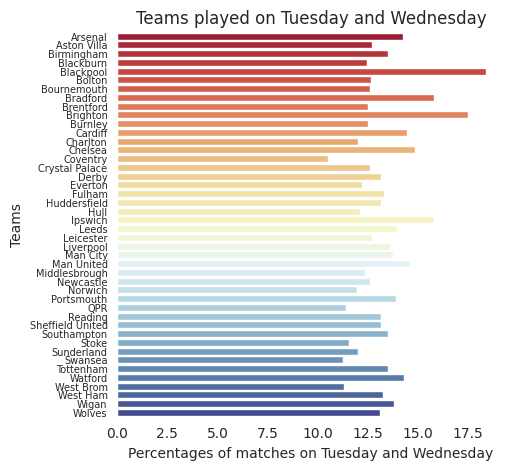

In [21]:
plt.figure(figsize=(5,5))
ax = sns.barplot(x="ratio", y="HomeTeam", data=match_all_wed_tue, hue="HomeTeam", palette="RdYlBu")
ax.set_title('Teams played on Tuesday and Wednesday')
ax.tick_params(axis='y', labelsize=7)
ax.set_ylabel('Teams')
ax.set_xlabel('Percentages of matches on Tuesday and Wednesday')
plt.show()

The above figure shows the ratio of matches played on Tuesday or Wednesday and the total matches in this dataset for each unique team. Blackburn played the most on these days. The overall ratios are close, which indicates the arrangement of midweek matches is fair for most teams via this figure. However, whether it is indeed fair needs to combine the detailed schedule. One can imagine that a team may perform poorly right after they played against the top 6 teams or had a strong competition at the match in the past weekend.

---
### Processing data
Now we will process data again for machine learning, which will also prepare train and test datasets.

Since the current dataset does not record information of players in transfermarket, the season factor becomes less useful. We will drop this and return to regular index.

In [22]:
# Change index from season to index
epl_df = epl_data.copy()
epl_df.index = range(epl_df.shape[0])
epl_df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HC,AC,HF,AF,HY,AY,HR,AR,matchDay
0,Charlton,Man City,4,0,H,2.0,0.0,H,17.0,8.0,...,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,Saturday
1,Chelsea,West Ham,4,2,H,1.0,0.0,H,17.0,12.0,...,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,Saturday
2,Coventry,Middlesbrough,1,3,A,1.0,1.0,D,6.0,16.0,...,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,Saturday
3,Derby,Southampton,2,2,D,1.0,2.0,A,6.0,13.0,...,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,Saturday
4,Leeds,Everton,2,0,H,2.0,0.0,H,17.0,12.0,...,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,Saturday


Since both FTR and HTR are objects, which show results via HomeWin, Draw, and AwayWin. Thus, we will replace these three characters with numerical values, 2, 1, and 0.

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
epl_df['FTR']= label_encoder.fit_transform(epl_df['FTR'])
epl_df['HTR']= label_encoder.fit_transform(epl_df['HTR'])

epl_df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HC,AC,HF,AF,HY,AY,HR,AR,matchDay
0,Charlton,Man City,4,0,2,2.0,0.0,2,17.0,8.0,...,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,Saturday
1,Chelsea,West Ham,4,2,2,1.0,0.0,2,17.0,12.0,...,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,Saturday
2,Coventry,Middlesbrough,1,3,0,1.0,1.0,1,6.0,16.0,...,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,Saturday
3,Derby,Southampton,2,2,1,1.0,2.0,0,6.0,13.0,...,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,Saturday
4,Leeds,Everton,2,0,2,2.0,0.0,2,17.0,12.0,...,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,Saturday


Again, following Icaro, we will give all teams the same weight.

In [24]:
def replace_to_number(epl_df):
    epl_df = pd.get_dummies(epl_df, columns=['HomeTeam'], prefix = ['HomeTeam'])
    epl_df = pd.get_dummies(epl_df, columns=['AwayTeam'], prefix = ['AwayTeam'])
    epl_df = pd.get_dummies(epl_df, columns=['HTR'], prefix = ['HTR'])
    epl_df = pd.get_dummies(epl_df, columns=['matchDay'], prefix = ['matchDay'])
    
    return epl_df

epl_df_extend = replace_to_number(epl_df)

In [25]:
# Take a look at new columns
# The original columns start from 0 to 16
epl_df_extend.columns[17:54]

Index(['HomeTeam_Arsenal', 'HomeTeam_Aston Villa', 'HomeTeam_Birmingham',
       'HomeTeam_Blackburn', 'HomeTeam_Blackpool', 'HomeTeam_Bolton',
       'HomeTeam_Bournemouth', 'HomeTeam_Bradford', 'HomeTeam_Brentford',
       'HomeTeam_Brighton', 'HomeTeam_Burnley', 'HomeTeam_Cardiff',
       'HomeTeam_Charlton', 'HomeTeam_Chelsea', 'HomeTeam_Coventry',
       'HomeTeam_Crystal Palace', 'HomeTeam_Derby', 'HomeTeam_Everton',
       'HomeTeam_Fulham', 'HomeTeam_Huddersfield', 'HomeTeam_Hull',
       'HomeTeam_Ipswich', 'HomeTeam_Leeds', 'HomeTeam_Leicester',
       'HomeTeam_Liverpool', 'HomeTeam_Man City', 'HomeTeam_Man United',
       'HomeTeam_Middlesbrough', 'HomeTeam_Newcastle', 'HomeTeam_Norwich',
       'HomeTeam_Portsmouth', 'HomeTeam_QPR', 'HomeTeam_Reading',
       'HomeTeam_Sheffield United', 'HomeTeam_Southampton', 'HomeTeam_Stoke',
       'HomeTeam_Sunderland'],
      dtype='object')

Now we can split train and test sets.

---
### Train using different models

In [26]:
from sklearn.model_selection import train_test_split
label = epl_df_extend['FTR']
features = epl_df_extend.iloc[:,3:epl_df.shape[1]]

y = np.ravel(label) # convert to 1D array
X = features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print("We have {} features involved under test_size = 0.3:".format(X_train.shape[1]))
print("The length of train set is {}.".format(X_train.shape[0]))
print("The length of test set is {}.".format(X_test.shape[0]))

X_train_test2, X_test_test2, y_train_test2, y_test_test2 = train_test_split(X, y, test_size=0.35, shuffle=False)

print("\nWe have {} features involved under test_size = 0.35:".format(X_train.shape[1]))
print("The length of train set is {}.".format(X_train_test2.shape[0]))
print("The length of test set is {}.".format(X_test_test2.shape[0]))

We have 18 features involved under test_size = 0.3:
The length of train set is 5802.
The length of test set is 2487.

We have 18 features involved under test_size = 0.35:
The length of train set is 5387.
The length of test set is 2902.


In [27]:
def pred_score_time(X_train, X_test, y_train, y_test, clf):
    t0 = time()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    t1 = round(time()-t0, 3)
    return acc, t1

In [28]:
def train_result(X_train, X_test, y_train, y_test, test_no):
    rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
    acc_rf, t_rf = pred_score_time(X_train, X_test, y_train, y_test, rf)

    dtc = tree.DecisionTreeClassifier()
    acc_tree, t_tree = pred_score_time(X_train, X_test, y_train, y_test, dtc)

    knn = KNeighborsClassifier(n_neighbors=20)
    acc_knn, t_knn = pred_score_time(X_train, X_test, y_train, y_test, knn)

    ada = AdaBoostClassifier()
    acc_ada, t_ada = pred_score_time(X_train, X_test, y_train, y_test, ada)

    nb = GaussianNB()
    acc_nb, t_nb = pred_score_time(X_train, X_test, y_train, y_test, nb)

    svm = SVC(kernel="rbf",C=10000)
    acc_svm, t_svm = pred_score_time(X_train, X_test, y_train, y_test, svm)
    
    result_test = {
        "Model": ["Random Forest", "Decision Tree", "K-nearest Neighbors", "AdaBoost", "Naive Bayes", "Support Vector Machine"],
        "Spending Time (s)": [t_rf, t_tree, t_knn, t_ada, t_nb, t_svm],
        "Accuracy Score": [acc_rf, acc_tree, acc_knn, acc_ada, acc_nb, acc_svm],
        "Group": [test_no] * 6
    }

    # Save all results into a dataframe
    df = pd.DataFrame(result_test)
    
    return df

In [29]:
df_test1 = train_result(X_train, X_test, y_train, y_test, test_no="original w. test_size = 0.3")
df_test1

,Model,Spending Time (s),Accuracy Score,Group
0,Random Forest,0.344,0.648975,original w. test_size = 0.3
1,Decision Tree,0.059,0.552875,original w. test_size = 0.3
2,K-nearest Neighbors,0.565,0.567752,original w. test_size = 0.3
3,AdaBoost,0.148,0.641335,original w. test_size = 0.3
4,Naive Bayes,0.004,0.630881,original w. test_size = 0.3
5,Support Vector Machine,69.633,0.592280,original w. test_size = 0.3


The accuracy scores are very close for different models, with the highest one being Random Forest and the second highest being K-nearest Neighbors. As aforementioned, the total data length is 8289 with 21 columns. Training using the Support Vector Machine costs significantly longer time.

In [30]:
# Get results for the second test
# Test 2 for test_size = 0.35
df_test2 = train_result(X_train_test2, X_test_test2, 
                        y_train_test2, y_test_test2, 
                        test_no="original w. test_size = 0.35")
df_test = df_test1.append(df_test2, ignore_index=True)
df_test2

,Model,Spending Time (s),Accuracy Score,Group
0,Random Forest,0.201,0.651620,original w. test_size = 0.35
1,Decision Tree,0.020,0.543074,original w. test_size = 0.35
2,K-nearest Neighbors,0.070,0.555134,original w. test_size = 0.35
3,AdaBoost,0.141,0.644728,original w. test_size = 0.35
4,Naive Bayes,0.003,0.624397,original w. test_size = 0.35
5,Support Vector Machine,57.917,0.595451,original w. test_size = 0.35


It seems the accuracy score with changing the test size from 0.3 to 0.35 varies very slightly. Thus, we will go with 0.3.

---
### Can we improve accuracy?
Since the accuracy is only above half, let us try if we can improve the accuracy using certain procedures.

#### 1. Rolling average
First, we will use the rolling average. This is quite straightforward since the results of the previous games sometimes might be able to predict the incoming ones. The good status may be maintained for a long time and vice versa.

In [31]:
# Start Over
epl_df_rolling_temp = epl_df.copy()
epl_df_rolling_temp.index = range(epl_df_rolling_temp.shape[0])

def rolling_averages(group, cols, new_cols):
    group = group.sort_index()
    # rolling average
    # closed = 'left', take the current week out
    rolling_stats = group[cols].rolling(3, closed='left').mean(skipna=True)
    group[new_cols] = rolling_stats
    # drop missing values
    group = group.dropna(subset=new_cols)
    return group

cols = ['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HC','AC','HF','AF','HY','AY','HR','AR']
new_cols = [f"{c}_rolling" for c in cols]

epl_df_rolling_temp = epl_df_rolling_temp.groupby("HomeTeam").apply(lambda x: rolling_averages(x, cols, new_cols))
epl_df_rolling_temp = epl_df_rolling_temp.droplevel('HomeTeam')
epl_df_rolling_temp.sort_index(axis=0, ascending=True, inplace=True)
epl_df_rolling_temp

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,HST_rolling,AST_rolling,HC_rolling,AC_rolling,HF_rolling,AF_rolling,HY_rolling,AY_rolling,HR_rolling,AR_rolling
59,Bradford,Southampton,0,1,0,0.0,1.0,0,14.0,6.0,...,4.000000,8.333333,5.333333,7.333333,14.000000,13.666667,0.333333,1.666667,0.000000,0.000000
60,Coventry,West Ham,0,3,0,0.0,2.0,0,9.0,12.0,...,2.333333,6.666667,6.666667,6.000000,13.666667,17.666667,2.666667,2.000000,0.333333,0.000000
61,Derby,Leeds,1,1,1,0.0,1.0,0,13.0,16.0,...,5.000000,5.333333,6.666667,8.000000,12.000000,11.666667,2.333333,1.333333,0.000000,0.000000
62,Ipswich,Arsenal,1,1,1,0.0,0.0,1,17.0,10.0,...,6.000000,3.666667,5.333333,5.000000,9.666667,10.666667,1.000000,2.666667,0.000000,0.000000
63,Liverpool,Sunderland,1,1,1,1.0,1.0,1,11.0,8.0,...,8.333333,4.333333,7.666667,4.000000,12.666667,10.666667,1.333333,2.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8284,Aston Villa,Tottenham,0,4,0,0.0,1.0,0,9.0,11.0,...,3.666667,2.666667,6.666667,5.666667,11.666667,9.666667,1.666667,2.000000,0.000000,0.000000
8285,Brentford,West Ham,2,0,2,0.0,0.0,1,15.0,5.0,...,2.333333,5.000000,3.666667,8.000000,8.333333,9.000000,1.666667,0.666667,0.333333,0.333333
8286,Leicester,Crystal Palace,2,1,2,2.0,0.0,2,12.0,11.0,...,3.333333,4.333333,4.000000,6.333333,9.666667,10.333333,1.000000,2.000000,0.000000,0.000000
8287,Norwich,Burnley,2,0,2,1.0,0.0,2,17.0,18.0,...,4.333333,7.333333,4.000000,8.333333,9.333333,13.666667,0.666667,3.000000,0.000000,0.000000


Now, our EPL dataframe has a lot of new columns.

In [32]:
# Weigh all teams
epl_df_rolling = replace_to_number(epl_df_rolling_temp)

In [33]:
# Again, esignate features and label
label_test3 = epl_df_rolling['FTR']
features_test3 = epl_df_rolling.iloc[:,3:epl_df_rolling.shape[1]]

In [34]:
# Spilt train and test sets
y = np.ravel(label_test3) # convert to 1D array
X = features_test3
X_train_test3, X_test_test3, y_train_test3, y_test_test3 = train_test_split(X, y, test_size=0.3, shuffle=False)

In [35]:
# Get results for the third test
# Test 3 for features with rolling average
df_test3 = train_result(X_train_test3, X_test_test3, y_train_test3, y_test_test3, test_no="rolling average")
df_test = df_test.append(df_test3, ignore_index=True)
df_test3

,Model,Spending Time (s),Accuracy Score,Group
0,Random Forest,0.296,0.646650,rolling average
1,Decision Tree,0.073,0.539216,rolling average
2,K-nearest Neighbors,0.072,0.541258,rolling average
3,AdaBoost,0.287,0.654003,rolling average
4,Naive Bayes,0.008,0.538807,rolling average
5,Support Vector Machine,33.614,0.557190,rolling average


Weird results. We can see the one via Random Forest is still at a similar level, while those via K-nearest Neighbors and Naive Bayes do drop. On the other hand, using a rolling average improves the one via Adaboost.

#### 2. Feature selection
Although it changes a bit, the effect is still not ideal. Now, let us try to drop some features using feature selection.

In [36]:
# Feature selection
label = epl_df_rolling['FTR']
features = epl_df_rolling.iloc[:,3:epl_df_rolling.shape[1]-1]

y = np.ravel(label) # convert to 1D array
X = features

bestfeatures = SelectKBest(score_func=mutual_info_classif, k=30)
fit = bestfeatures.fit(X,y)
featureScores = pd.DataFrame({'features':X.columns,'score':fit.scores_})
print(featureScores.nlargest(30,'score'))

                      features     score
120                      HTR_2  0.155556
118                      HTR_0  0.137725
0                         HTHG  0.114327
1                         HTAG  0.100581
4                          HST  0.064327
5                          AST  0.054684
3                           AS  0.045989
119                      HTR_1  0.028685
2                           HS  0.027726
18                  HS_rolling  0.024242
14                FTHG_rolling  0.024112
66         HomeTeam_Sunderland  0.018570
21                 AST_rolling  0.017124
10                          HY  0.016289
76         AwayTeam_Birmingham  0.014369
19                  AS_rolling  0.014068
27                  AY_rolling  0.011836
87            AwayTeam_Chelsea  0.011499
54          HomeTeam_Liverpool  0.011158
36        HomeTeam_Bournemouth  0.010981
84            AwayTeam_Burnley  0.010673
16                HTHG_rolling  0.010354
53          HomeTeam_Leicester  0.009741
34          Home

As we can see, scores of different features are in a wide range. Except for those fixed factors such as goals, shots, fouls, teams at home and away stadiums also matter here, which could hint that they may perform better in one.

In [37]:
# Get results for the 4th test
# Test 4 after feature selection
new_features_30 = epl_df_rolling[featureScores.nlargest(30,'score')['features'].values]
X_train_test4, X_test_test4, y_train_test4, y_test_test4 = train_test_split(new_features_30, y, test_size=0.3, shuffle=False)

df_test4 = train_result(X_train_test4, X_test_test4, y_train_test4, y_test_test4, test_no="rolling with feature selection (30)")
df_test = df_test.append(df_test4, ignore_index=True)
df_test4

,Model,Spending Time (s),Accuracy Score,Group
0,Random Forest,0.210,0.650327,rolling with feature selection (30)
1,Decision Tree,0.027,0.548203,rolling with feature selection (30)
2,K-nearest Neighbors,0.060,0.579248,rolling with feature selection (30)
3,AdaBoost,0.163,0.654412,rolling with feature selection (30)
4,Naive Bayes,0.004,0.583333,rolling with feature selection (30)
5,Support Vector Machine,50.357,0.600082,rolling with feature selection (30)


Anything change? It seems we still have similar scores. Anyway, let us try fewer features.

In [38]:
# Get results for the 5th test
# Test 5 after feature selection with 10 features
new_features_10 = epl_df_rolling[featureScores.nlargest(10,'score')['features'].values]
X_train_test5, X_test_test5, y_train_test5, y_test_test5 = train_test_split(new_features_10, y, test_size=0.3, shuffle=False)

df_test5 = train_result(X_train_test5, X_test_test5, y_train_test5, y_test_test5, test_no="rolling with feature selection (10)")
df_test = df_test.append(df_test5, ignore_index=True)
df_test5

,Model,Spending Time (s),Accuracy Score,Group
0,Random Forest,0.181,0.637255,rolling with feature selection (10)
1,Decision Tree,0.014,0.545343,rolling with feature selection (10)
2,K-nearest Neighbors,0.090,0.610294,rolling with feature selection (10)
3,AdaBoost,0.134,0.656046,rolling with feature selection (10)
4,Naive Bayes,0.004,0.635212,rolling with feature selection (10)
5,Support Vector Machine,50.368,0.629085,rolling with feature selection (10)


Quite surprising! We now have almost all train models hit above 0.6, except for the Decision Tree.

#### 3. Principle Component Analysis
Does the change of number of features contribute the most to the accuracy? Perhaps we can try Principle Component Analysis (PCA) to reduce the number of features while keeping the information as much as possible.

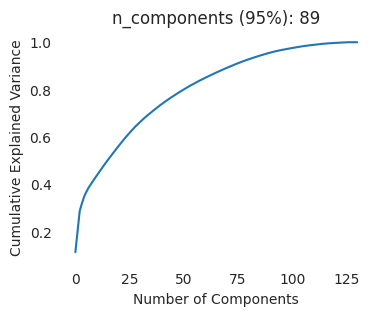

In [39]:
# Principle Component Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(epl_df_rolling)

# Apply PCA
pca = PCA()
pca.fit(scaled_data)

cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.95]) + 1

# Plot to show where the best n_components is
plt.figure(figsize=(4, 3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('n_components (95%): {}'.format(n_components))
plt.show()

In [40]:
# Test 6 by applying PCA and n_components
X_train, X_test, y_train, y_test = train_test_split(features, y)
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

df_test6 = train_result(X_train_pca, X_test_pca, y_train, y_test, test_no="rolling with PCA")
df_test = df_test.append(df_test6, ignore_index=True)
df_test6

,Model,Spending Time (s),Accuracy Score,Group
0,Random Forest,2.127,0.646569,rolling with PCA
1,Decision Tree,0.664,0.520588,rolling with PCA
2,K-nearest Neighbors,0.023,0.564706,rolling with PCA
3,AdaBoost,2.953,0.635784,rolling with PCA
4,Naive Bayes,0.004,0.593137,rolling with PCA
5,Support Vector Machine,2.806,0.589706,rolling with PCA


Well, they all drop...    
"Football, bloody hell!" - Sir Alex Ferguson

In [41]:
df_test

,Model,Spending Time (s),Accuracy Score,Group
0,Random Forest,0.344,0.648975,original w. test_size = 0.3
1,Decision Tree,0.059,0.552875,original w. test_size = 0.3
2,K-nearest Neighbors,0.565,0.567752,original w. test_size = 0.3
3,AdaBoost,0.148,0.641335,original w. test_size = 0.3
4,Naive Bayes,0.004,0.630881,original w. test_size = 0.3
5,Support Vector Machine,69.633,0.592280,original w. test_size = 0.3
6,Random Forest,0.201,0.651620,original w. test_size = 0.35
7,Decision Tree,0.020,0.543074,original w. test_size = 0.35
8,K-nearest Neighbors,0.070,0.555134,original w. test_size = 0.35
9,AdaBoost,0.141,0.644728,original w. test_size = 0.35


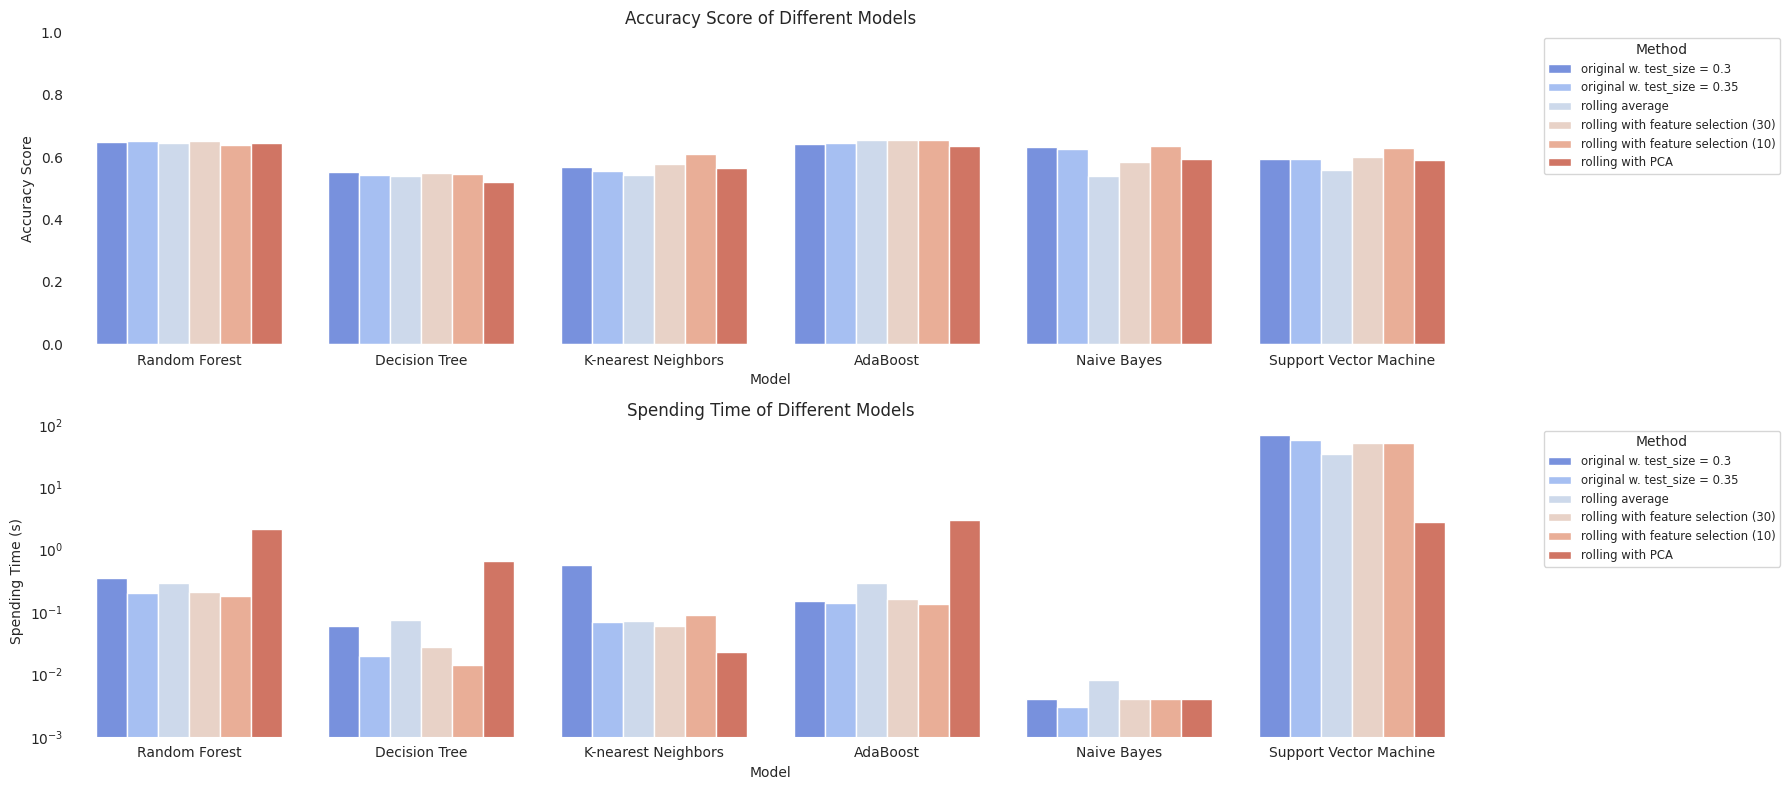

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(18, 8))

sns.barplot(x="Model", y="Accuracy Score", hue="Group", data=df_test, ax=axes[0], palette="coolwarm")
axes[0].set_title("Accuracy Score of Different Models")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Accuracy Score")
axes[0].set_ylim(0, 1)
axes[0].legend(title="Method", fontsize='small', bbox_to_anchor=(1.05, 1))

sns.barplot(x="Model", y="Spending Time (s)", hue="Group", data=df_test, ax=axes[1], palette="coolwarm")
axes[1].set_yscale('log')
axes[1].set_ylim(0.001, 100)
axes[1].set_title("Spending Time of Different Models")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Spending Time (s)")
axes[1].legend(title="Method", fontsize='small', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

### Prediction for Man United
Since the relatively accurate model is adaboost with the rolling average, we will directly extract MUFC data from the rolling average data frame.

In [43]:
mufc_data_rolling_temp = epl_df_rolling_temp[(epl_df_rolling_temp['HomeTeam'] == 'Man United') | 
                    (epl_df_rolling_temp['AwayTeam'] == 'Man United')]
mufc_data_rolling_temp

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,HST_rolling,AST_rolling,HC_rolling,AC_rolling,HF_rolling,AF_rolling,HY_rolling,AY_rolling,HR_rolling,AR_rolling
64,Man United,Chelsea,3,3,1,3.0,2.0,2,11.0,13.0,...,9.333333,3.666667,5.333333,2.000000,12.333333,12.333333,0.333333,1.666667,0.000000,0.000000
76,Arsenal,Man United,1,0,2,1.0,0.0,2,7.0,13.0,...,11.333333,3.333333,8.666667,6.000000,14.000000,16.000000,1.000000,2.333333,0.333333,0.666667
84,Leicester,Man United,0,3,0,0.0,1.0,0,10.0,16.0,...,5.333333,3.666667,8.333333,3.666667,10.666667,11.666667,1.333333,0.666667,0.000000,0.000000
93,Man United,Leeds,3,0,2,1.0,0.0,2,26.0,5.0,...,8.000000,3.333333,5.666667,3.000000,15.000000,14.333333,1.333333,2.000000,0.000000,0.000000
104,Man United,Southampton,5,0,2,2.0,0.0,2,16.0,12.0,...,8.666667,2.000000,8.000000,4.000000,14.000000,17.000000,1.333333,2.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8232,Man United,Watford,0,0,1,0.0,0.0,1,22.0,10.0,...,6.000000,2.666667,4.666667,3.000000,9.666667,10.333333,2.666667,0.666667,0.000000,0.333333
8245,Man City,Man United,4,1,2,2.0,1.0,2,24.0,5.0,...,5.666667,2.666667,9.333333,1.333333,7.666667,8.666667,0.000000,1.666667,0.000000,0.000000
8253,Man United,Tottenham,3,2,2,2.0,1.0,2,10.0,10.0,...,6.000000,3.000000,5.000000,3.000000,7.333333,10.000000,2.333333,0.333333,0.000000,0.333333
8274,Man United,Leicester,1,1,1,0.0,0.0,1,11.0,11.0,...,5.333333,2.666667,6.000000,3.333333,6.000000,8.000000,1.666667,0.666667,0.000000,0.333333


In [44]:
# Weigh all teams
mufc_data_rolling = replace_to_number(mufc_data_rolling_temp)

# Feature selection
label = mufc_data_rolling['FTR']
features = mufc_data_rolling.iloc[:,3:mufc_data_rolling.shape[1]-1]

y = np.ravel(label)
X = features

bestfeatures = SelectKBest(score_func=mutual_info_classif, k=30)
fit = bestfeatures.fit(X,y)
featureScores = pd.DataFrame({'features':X.columns,'score':fit.scores_})
print(featureScores.nlargest(30,'score'))

                   features     score
118                   HTR_2  0.181385
116                   HTR_0  0.154737
1                      HTAG  0.139973
98      AwayTeam_Man United  0.137753
0                      HTHG  0.134877
4                       HST  0.095690
56      HomeTeam_Man United  0.090859
12                       HR  0.079063
5                       AST  0.061305
62         HomeTeam_Reading  0.047565
11                       AY  0.044302
22               HC_rolling  0.040954
67         HomeTeam_Swansea  0.040229
57   HomeTeam_Middlesbrough  0.039726
23               AC_rolling  0.036977
14             FTHG_rolling  0.036209
3                        AS  0.035200
2                        HS  0.035184
76      AwayTeam_Birmingham  0.034486
85         AwayTeam_Chelsea  0.032643
36     HomeTeam_Bournemouth  0.032601
107          AwayTeam_Stoke  0.031336
32      HomeTeam_Birmingham  0.030355
91    AwayTeam_Huddersfield  0.030165
18               HS_rolling  0.029895
100      Awa

In [45]:
# Get results for the 4th test
# Test 4 after feature selection
mufc_new_features_10 = mufc_data_rolling[featureScores.nlargest(10,'score')['features'].values]
X_train_test7, X_test_test7, y_train_test7, y_test_test7 = train_test_split(mufc_new_features_10, y, test_size=0.3, shuffle=False)

df_test7 = train_result(X_train_test7, X_test_test7, y_train_test7, y_test_test7, test_no="rolling with feature selection (30)")
df_test7

,Model,Spending Time (s),Accuracy Score,Group
0,Random Forest,0.051,0.601626,rolling with feature selection (30)
1,Decision Tree,0.002,0.536585,rolling with feature selection (30)
2,K-nearest Neighbors,0.007,0.597561,rolling with feature selection (30)
3,AdaBoost,0.061,0.605691,rolling with feature selection (30)
4,Naive Bayes,0.002,0.487805,rolling with feature selection (30)
5,Support Vector Machine,0.455,0.605691,rolling with feature selection (30)


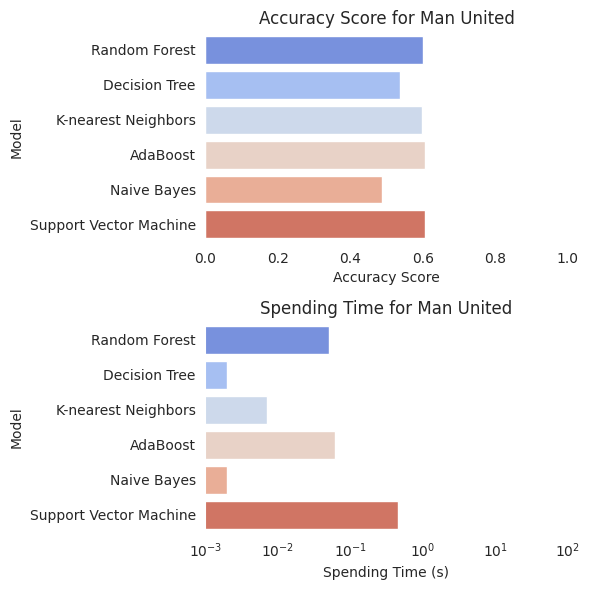

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

sns.barplot(x="Accuracy Score", y="Model", hue="Model", data=df_test7, ax=axes[0], palette="coolwarm")
axes[0].set_title("Accuracy Score for Man United")
axes[0].set_ylabel("Model")
axes[0].set_xlabel("Accuracy Score")
axes[0].set_xlim(0, 1)
# axes[0].tick_params(axis='x', labelsize=8)

sns.barplot(x="Spending Time (s)", y="Model", hue="Model", data=df_test7, ax=axes[1], palette="coolwarm")
axes[1].set_xscale('log')
axes[1].set_xlim(0.001, 100)
axes[1].set_title("Spending Time for Man United")
axes[1].set_ylabel("Model")
axes[1].set_xlabel("Spending Time (s)")
# axes[1].tick_params(axis='x', labelsize=8, rotation=90)

plt.tight_layout()
plt.show()

---
### Summary and Discussion

**Dataset**
- The original dataset is relatively complete, which leaves limited scope for preprocessing.
- The information and features within this dataset are highly useful and align well with post-match statistics commonly used to evaluate team performance.

**Models**
- This project adopts six models: Naive Bayes (NB), Support Vector Machine (SVM), AdaBoost, K-Nearest Neighbors, Decision Tree, and Random Forest.
- The initial dataset yields an accuracy score of approximately 0.5 to 0.6x for various models. Consequently, we have implemented different methods to enhance this accuracy.
    - Rolling average: the reason we use the rolling average is the average performance in preceding matches may affect subsequent ones. However, this approach yielded minimal improvement in accuracy.
    - Feature selection: experimented with 30 and 10 features, and it turns out the latter resulted in a better accuracy score. This could indicate certain features, such as half-time results, are more influential. This is understandable as leading at half-time can lower their pressure and thus results in a happy ending very likely.
    - Principle Component Analysis (PCA): PCA was employed to assess whether reducing features would yield better scores. The answer seems to be affirmative since all scores drop. 
- SVM is more time-consuming under each condition. Both Random Forest and AdaBoost stability across the tested methods and conditions. Naive Bayes has a clear variance with different methods. Notice that one should use Naive Bayes with caution since it could be an improper model for predicting human-involved seasonal matches.
    
    
**Insights from This Project**
- Whether each match is independent is debatable. From my perspective, it is not only since the status of the team could last longer. The news, media, rumors, and other external factors could contribute to such a dependent result as well.
- While the dataset adequately reflects team performance on a monthly or yearly basis, it falls short in predicting match outcomes. There are several key factors needed to be incorported if one would like to dig into this such as  the starting lineup, tactical formations, the key players, and rating of players and manangers, etc. 
- For given dataset, we did not include Referee nor make fully use of match day. In fact, the influence of referees and the timing of matches relative to previous ones are factors worth considering as well.

**Future works**
- May try deep neural network later, though there are concerns about the dataset's comprehensiveness and the interpretability of the results.
- Consideration of alternative datasets or the compilation of a new dataset is underway.
- Stay tuned!